In [1]:
import numpy as np
import scipy.io as sio
import random
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine

%matplotlib inline

# 一、导入数据加数据处理阶段

In [2]:
# 导入数据
path = os.path.join("E:\Eric_HSI\hyperspectral_datasets")
PaviaU = os.path.join(path,'paviaU.mat')
PaviaU_gt = os.path.join(path,'paviaU_gt.mat')
method_path = 'RF'

In [3]:
# 加载数据，返回值为一个字典内嵌ndarray的数据结构
data = sio.loadmat(PaviaU)
data_gt = sio.loadmat(PaviaU_gt)
im = data['data']  # im为样本点的光谱值的ndarray
imGIS = data_gt['groundT']  # imGIS样本点的标签值组成的ndarray

In [4]:
# 归一化，这个归一化的方法有点不一样
im = (im - float(np.min(im)))
im = im/np.max(im)

In [5]:
im.shape  # (610, 340, 103)
imGIS.shape  # (610, 340)
np.max(imGIS)

9

In [6]:
# 参数设置
# 训练数据集的个数200, deepth为通道数103，classes为类别数
sample_num = 200
deepth = im.shape[2]
classes = np.max(imGIS)


In [7]:
# 只对一个通道遍历所有的标签值，对每一个标签值进行分类组合，
# 得到{1类：对应点坐标位置列表，2类：对应的坐标位置列表；等等}
# pos  ->  position

data_pos = {}
train_pos = {}
test_pos = {}

for i in range(1,classes+1):
    data_pos[i]=[]
    train_pos[i]=[]
    test_pos[i] = []

# 构造一个总的data_pos
for i in range(imGIS.shape[0]):
    for j in range(imGIS.shape[1]):
        for k in range(1,classes+1):
            if imGIS[i,j]==k:
                data_pos[k].append([i,j])
                continue

In [8]:
data_pos.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
# 查看信息
# 取出键为1的ndarray 中的前10个数，也就是标签为1的前10个像素是位置坐标位置
data_pos[1][:10]

[[0, 91],
 [0, 92],
 [0, 93],
 [0, 94],
 [0, 95],
 [0, 96],
 [0, 97],
 [0, 98],
 [0, 112],
 [0, 113]]

In [10]:
# for k,v in data_pos.items():
#     print(len(v))

In [11]:
# 取出测试集和训练集,此过程后训练集和测试集为字典，和上面构造data_pos类似
for i in range(1,classes+1):
    # Returns a new list containing elements from the population while
    #         leaving the original population unchanged. 大小为sample_num
    indexies = random.sample(range(len(data_pos[i])),sample_num)
    for k in range(len(data_pos[i])):
        if k not in indexies:
            test_pos[i].append(data_pos[i][k])
        else:
            train_pos[i].append(data_pos[i][k])

In [12]:
# for k,v in test_pos.items():
#     print(len(v))

In [13]:
len(train_pos)  #9
len(train_pos[2])  # 200
# type(train_pos) dict 123456789
train_pos[1][:10]  

[[2, 98],
 [5, 109],
 [6, 98],
 [10, 112],
 [11, 108],
 [13, 101],
 [20, 102],
 [30, 110],
 [32, 117],
 [35, 115]]

In [14]:
# dict train_pos change to list train, but list include n ndarray
# 将位置信息转化光谱值信息，即将坐标值转化为其对应的光谱值，此过程得到一个为列表
# 准确的说是列表内嵌套 ndarray 的结构，ndarray有 1 维，个数103
train = []   # 训练样本的总个数，每个类别分别有200个样本，总共有1800个样本
train_label = []
test = []
test_label = []

for i in range(1,len(train_pos)+1):   # 9个类
    for j in range(len(train_pos[i])):   # 200个样本
        row,col = train_pos[i][j]
        train.append(im[row,col])   #### 一下子传入103维 ####
        train_label.append(i)
        
for i in range(1,len(test_pos)+1):
    for j in range(len(test_pos[i])):
        row,col = test_pos[i][j]
        test.append(im[row,col])
        test_label.append(i)

In [15]:
# len(train) # 1800
# len(train_label)  # 1800
# type(train)  # list
# len(test)  # 40976
# type(test)  # list
# train[1].shape  # list 中的第一个训练集

### np.array & np.asarray
- array和asarray都可以将结构数据转化为ndarray，
- 但是主要区别就是当数据源是ndarray时，array仍然会copy出一个副本，占用新的内存，但asarray不会。

In [16]:
# last step: 化为ndarray!
train = np.asarray(train)
train_label = np.asarray(train_label)
train.shape,train_label

((1800, 103), array([1, 1, 1, ..., 9, 9, 9]))

In [17]:
# 创建 result 文件夹，用于存放未来的输出的结果
# if not os.path.exists(os.path.join(method_path,'result')):
#     os.makedirs(os.path.join(method_path,'result'))

# 创建 result 文件夹，用于存放未来的输出的结果
if not os.path.exists(os.path.join('result')):
    os.makedirs(os.path.join('result'))

# 二、建立模型和模型训练阶段

In [18]:
# 处理数据完成，现在开始应用sklearning
# clf = DecisionTreeClassifier(random_state=0)  # 决策树，state控制随机性
rfc = RandomForestClassifier(n_estimators=10, random_state=0)  # 随机森林，state生成一片固定的森林, n_estimators=10, 10 棵树组成
# clf = clf.fit(train, train_label)
rfc = rfc.fit(test, test_label)
# score_c = clf.score(test, test_label)
score_r = rfc.score(test, test_label)
# print("Single Tree:{}".format(score_c))
print("Random Forest:{}".format(score_r))

Random Forest:0.9953143303397111


In [19]:
# 构建二维的特征，才能用于预测
# test[1].reshape(-1,len(test[1]))

In [20]:
# 构造一个类别数乘类别数的矩阵，输出结果为混淆矩阵
C = np.max(imGIS)
matrix = np.zeros((C,C))
# 对所有测试像素点进行预测
for i in range(len(test)):
    # 增加一维然后进行预测
    r = rfc.predict(test[i].reshape(-1,len(test[i])))
    # 构建混淆矩阵
    matrix[r-1,test_label[i]-1] += 1

In [21]:
# 每个类别的精度
ac_list = []
for i in range(len(matrix)):
    # 精度为混淆矩阵中预测正确即对角线中的个数 除 总数即一整列
    ac = matrix[i, i] / sum(matrix[:, i])
    ac_list.append(ac)
    print(i+1,'class:','(', matrix[i, i], '/', sum(matrix[:, i]), ')', ac)

1 class: ( 6420.0 / 6431.0 ) 0.9982895350645312
2 class: ( 18440.0 / 18449.0 ) 0.9995121686812294
3 class: ( 1885.0 / 1899.0 ) 0.9926276987888363
4 class: ( 2844.0 / 2864.0 ) 0.9930167597765364
5 class: ( 1144.0 / 1145.0 ) 0.9991266375545852
6 class: ( 4738.0 / 4829.0 ) 0.9811555187409402
7 class: ( 1109.0 / 1130.0 ) 0.9814159292035398
8 class: ( 3457.0 / 3482.0 ) 0.9928202182653647
9 class: ( 747.0 / 747.0 ) 1.0


In [22]:
# 输出混淆矩阵
print('confusion matrix:')
print(matrix.astype(int))
# print(matrix[:, 1])    # 列
# matrix[1]      # 行

confusion matrix:
[[ 6420     0     3     0     1     1    21     4     0]
 [    2 18440     1    18     0    90     0     2     0]
 [    0     0  1885     0     0     0     0    19     0]
 [    0     5     0  2844     0     0     0     0     0]
 [    0     0     0     1  1144     0     0     0     0]
 [    1     4     0     1     0  4738     0     0     0]
 [    1     0     0     0     0     0  1109     0     0]
 [    7     0    10     0     0     0     0  3457     0]
 [    0     0     0     0     0     0     0     0   747]]


In [23]:
# 输出总体精度
print('total right num:', np.sum(np.trace(matrix)))
print('total test num:',np.sum(matrix))
accuracy = np.sum(np.trace(matrix)) / np.sum(matrix)
print('Overall accuracy:', accuracy)

total right num: 40784.0
total test num: 40976.0
Overall accuracy: 0.9953143303397111


In [24]:
# 输出kappa 系数和 平均精度
kk = 0
for i in range(matrix.shape[0]):
    kk += np.sum(matrix[i]) * np.sum(matrix[:, i])
pe = kk / (np.sum(matrix) * np.sum(matrix))
pa = np.trace(matrix) / np.sum(matrix)
kappa = (pa - pe) / (1 - pe)
ac_list = np.asarray(ac_list)
aa = np.mean(ac_list)
print('Average accuracy:',aa)
print('Kappa:', kappa)

Average accuracy: 0.9931071628972847
Kappa: 0.9936826592696592


In [25]:
# 将结果保存在文件中
sio.savemat(os.path.join('result', 'result.mat'), {'oa': accuracy,'aa':aa,'kappa':kappa,'ac_list':ac_list,'matrix':matrix})

# 绘图阶段

In [26]:
# 绘图
# 控制开关，False 输出原始图像，True 输出预测的图像
# 这个预测图像是对没有标记的图像使用模型，进行预测，然后输出

# 这句话的意思是test_background # 是否对背景进行预测
test_bg = False
# test_bg = True

# 输出的想的尺寸大小
iG = np.zeros((imGIS.shape[0],imGIS.shape[1]))

# 在iG尺寸中填充像素的值
for i in range(imGIS.shape[0]):
    for j in range(imGIS.shape[1]):
        if imGIS[i,j] == 0:
            # 控制输出是原图 or 预测图
            if test_bg:
                iG[i,j] = (rfc.predict(im[i,j].reshape(-1,len(im[i,j]))))
            else:
                iG[i,j]=0
        else:
            iG[i,j] = (rfc.predict(im[i,j].reshape(-1,len(im[i,j]))))

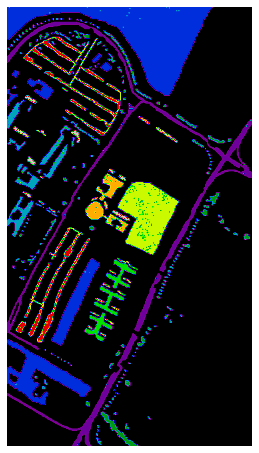

origin graph decode map get finished


In [27]:
# pcolor是用颜色图示数据，pcolor 实际上是画出一个个 grid，不同的数值有不同的grid

de_map = iG[::-1]  # 切片，获取从后向前排列的元素
fig, _ = plt.subplots()
height, width = de_map.shape
fig.set_size_inches(width/100.0, height/100.0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
plt.axis('off')
plt.axis('equal')
plt.imshow(de_map, 'nipy_spectral')
plt.savefig(os.path.join('result', 'decode_map1.png'),format='png',dpi=600)#bbox_inches='tight',pad_inches=0)
# plt.close()
plt.show()
print('origin graph decode map get finished')

In [28]:
# test_bg = True

# # 输出的想的尺寸大小
# iG = np.zeros((imGIS.shape[0],imGIS.shape[1]))

# # 在iG尺寸中填充像素的值
# for i in range(imGIS.shape[0]):
#     for j in range(imGIS.shape[1]):
#         if imGIS[i,j] == 0:
#             # 控制输出是原图 or 预测图
#             if test_bg:
#                 iG[i,j] = (rfc.predict(im[i,j].reshape(-1,len(im[i,j]))))
#             else:
#                 iG[i,j]=0
#         else:
#             iG[i,j] = (rfc.predict(im[i,j].reshape(-1,len(im[i,j]))))

In [29]:
# de_map = iG[::-1]  # 切片，获取从后向前排列的元素
# fig, _ = plt.subplots()
# height, width = de_map.shape
# fig.set_size_inches(width/100.0, height/100.0)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
# plt.axis('off')
# plt.axis('equal')
# # plt.pcolor(de_map, 'nipy_spectral')
# plt.imshow(de_map, 'nipy_spectral')
# plt.savefig(os.path.join('result', 'decode_map2.png'),format='png',dpi=600)#bbox_inches='tight',pad_inches=0)
# # plt.close()
# plt.show()
# print('predict graph decode map get finished')